# MAP@3 - Deepseekmath-7b-It [TPU Training]

In this notebook we train deepseekmath-7b-it in bf16 for 2 epochs. The competition requires heavy compute resources, and Kaggle/Collab provides free TPU. So, we try here to use them. Since 4-8 bit quantization isn't supported on Kaggle TPUs, we'll train in bf16/fp16 precision using model parallelism to fit larger models. We take 

We're using **Deepseekmath-7b-It** here, but you can swap in any model that fits the memory constraints. The key is efficient TPU utilization and proper sharding.

**Note:** This is a training-only notebook. Inference and submission will be separate.

---

### TPU Configuration Overview
TPU v3-8 has 8GB memory per core (64GB total). A 7B model in fp16 needs ~14GB, so we use SPMD (Single Program Multiple Data) to shard the model across cores.

**Sharding Strategy:**
- Attention layers: Split across model parallel dimension
- FFN layers: Split to balance compute and memory
- Embeddings: Replicated for efficiency

---

### Training Hyperparameters
Key settings optimized for TPU v3-8 and competition metric:
- **Learning rate**: 2e-4 with cosine warmup schedule, usually high lr works well for lora.
- **Batch size**: 8 (you can try high with grad accum).

and more see CFG

I have kept configs like hf trainer, and it's all open configurable and so feel free to tweak. 

Upvote if you find this helpful or learned something!

# Import libs 

Install tpu specific and then import 

In [1]:
# Install libs, run once and then comment
!pip uninstall -qq tensorflow -y
!pip install -qq transformers==4.41.2
!pip install -qq accelerate==1.10.1 #not required for tpu runtime, keeping to not have transformer dependency problem
!pip install -qq peft==0.10.0
!pip install -qq torch==2.6.0
!pip install -qq 'torch_xla[tpu]==2.6.0' -f https://storage.googleapis.com/libtpu-releases/index.html

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.18.0 requires torch==2.3.0, but you have torch 2.6.0 which is incompatible.
torchaudio 2.3.0 requires torch==2.3.0, but you have torch 2.6.0 which is incompatible.


In [2]:
import os
import gc
import re
from time import time
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder
import time
import os
import glob
from tqdm.auto import tqdm

import torch
from sklearn.model_selection import train_test_split

from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                        AutoTokenizer, Qwen2Config, get_cosine_schedule_with_warmup)
from transformers import LlamaConfig  # Import LlamaConfig for DeepSeek
from peft import  PeftModel,  get_peft_model, LoraConfig, TaskType
import torch.nn.functional as F
from IPython.display import display, Math, Latex

# import torch_xla.debug.profiler as xp
import torch_xla.core.xla_model as xm
import torch_xla.runtime as xr

xr.use_spmd()
import torch_xla.distributed.spmd as xs
from torch.optim import AdamW
from torch_xla.distributed.spmd import Mesh

import torch.nn as nn
import re
tqdm.pandas()

print(f'Torch Version: {torch.__version__}')

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/usr/local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


/usr/local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Torch Version: 2.6.0+cu124


# Configs
Tweak and optimize.

In [3]:
class CFG:
    SEED = 42 
    MODEL_NAME = '/kaggle/input/deepseek-math-7b-instruct/transformers/main/1'
    NUM_EPOCHS = 2
    BATCH_SIZE = 8
    EVAL_BATCH_SIZE = 8
     
    MAX_LENGTH = 256
    WARMUP_RATIO = 0.1
    LR = 2e-4 #lora likes high
    
    # Lora configs
    NUM_LABELS = 65 
    LORA_RANK = 8
    LORA_ALPHA = 16
    DROPOUT = 0.05
    LORA_MODULES = ["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"] 
    
    # Gradient accumulation
    GRADACCUM = 1
    
    # Evaluation strategy
    VAL_SPLIT = 0.1
    EVAL_STRATEGY = "steps"  # "epoch", "steps", "no"
    EVAL_STEPS = 2000  # Only used if EVAL_STRATEGY = "steps"
    
    # Save strategy  
    SAVE_STRATEGY = "epoch"  # "epoch", "steps", "no"
    SAVE_STEPS = 1000  # Only used if SAVE_STRATEGY = "steps"
    SAVE_TOTAL_LIMIT = 2  # Keep only 2 most recent checkpoints
    
    # Output directory
    OUT_DIR = "checkpoints"
    
    # Additional training parameters
    WEIGHT_DECAY = 0.01
    MAX_GRAD_NORM = 1.0  
    
DEVICE = xm.xla_device() # Initialize TPU Device

In [4]:
def set_seeds(seed):
    """Set seeds for reproducibility """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # Set seed for all TPU cores
    xm.set_rng_state(seed, device=xm.xla_device())  

set_seeds(seed=CFG.SEED)

# Utils
Utility functions we will use in notebook.

In [5]:
def get_token_lengths(texts):
    # tokenize and receive input_ids for reach text
    input_ids = tokenizer(texts.tolist(), return_tensors='np')['input_ids']
    # return length of inputs_ids for each text
    return [len(t) for t in input_ids]

def create_dataset(input_ids, attention_masks, labels, batch_size, shuffle=True):
    N_SAMPLES = labels.shape[0]
    IDXS = np.arange(N_SAMPLES - (N_SAMPLES % batch_size))
    while True:
        if shuffle:
            np.random.shuffle(IDXS)
        
        for idxs in IDXS.reshape(-1, batch_size):
            input_ids_batch = torch.tensor(input_ids[idxs]).to(DEVICE)
            attention_mask_batch = torch.tensor(attention_masks[idxs]).to(DEVICE)
            labels_batch = torch.tensor(labels[idxs], dtype=torch.long).to(DEVICE)  # torch.long for classification
            
            # Shard Over TPU Nodes if applicable
            xs.mark_sharding(input_ids_batch, mesh, (0, 1))
            xs.mark_sharding(attention_mask_batch, mesh, (0, 1))
            xs.mark_sharding(labels_batch, mesh, (0,))  # Labels are 1D
            
            yield input_ids_batch, attention_mask_batch, labels_batch

def compute_map3(y_true, y_pred_probs):
    """Compute MAP@3 metric"""
    top3 = np.argsort(-y_pred_probs, axis=1)[:, :3]
    match = (top3 == y_true[:, None])
    map3 = 0
    for i in range(len(y_true)):
        if match[i, 0]:
            map3 += 1.0
        elif match[i, 1]:
            map3 += 1.0 / 2
        elif match[i, 2]:
            map3 += 1.0 / 3
    return map3 / len(y_true)

def evaluate_model(model, val_dataset, steps_per_val_epoch):
    """Evaluate model on validation set"""
    model.eval()
    val_losses = []
    val_y_true = []
    val_y_probs = []
    
    with torch.no_grad():
        for step in range(steps_per_val_epoch):
            input_ids, attention_mask, labels = next(val_dataset)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.to(dtype=torch.float32)
            
            loss = LOSS_FN(logits, labels.to(dtype=torch.float32))
            val_losses.append(float(loss))
            
            probs = F.softmax(logits, dim=-1)
            val_y_true.extend(labels.cpu().tolist())
            val_y_probs.extend(probs.detach().cpu().numpy())
    
    val_loss = np.mean(val_losses)
    val_map3 = compute_map3(np.array(val_y_true), np.array(val_y_probs))
    
    model.train()
    return val_loss, val_map3

def manage_checkpoints(save_dir, limit):
    """Keep only the most recent checkpoints based on SAVE_TOTAL_LIMIT"""
    if limit <= 0:
        return
        
    checkpoints = glob.glob(os.path.join(save_dir, "model_step_*.pth"))
    checkpoints.extend(glob.glob(os.path.join(save_dir, "model_epoch_*.pth")))
    
    if len(checkpoints) > limit:
        # Sort by modification time
        checkpoints.sort(key=os.path.getmtime)
        # Remove oldest checkpoints
        for checkpoint in checkpoints[:-limit]:
            try:
                os.remove(checkpoint)
                # Also remove corresponding optimizer file
                opt_file = checkpoint.replace("model_", "optimizer_")
                if os.path.exists(opt_file):
                    os.remove(opt_file)
            except:
                pass

def save_checkpoint(epoch, step, val_map3=None):
    """Save model and optimizer checkpoints"""
    if CFG.SAVE_STRATEGY == "no":
        return
        
    if val_map3 is not None:
        model_path = os.path.join(CFG.OUT_DIR, f'model_epoch_{epoch}_map3_{val_map3:.4f}.pth')
        opt_path = os.path.join(CFG.OUT_DIR, f'optimizer_epoch_{epoch}.pth')
    else:
        model_path = os.path.join(CFG.OUT_DIR, f'model_step_{step}.pth')
        opt_path = os.path.join(CFG.OUT_DIR, f'optimizer_step_{step}.pth')
    
    xm.save({k: v.cpu() for k, v in model.named_parameters() if v.requires_grad}, model_path)
    xm.save(OPTIMIZER.state_dict(), opt_path)
    
    # Manage checkpoint limit
    manage_checkpoints(CFG.OUT_DIR, CFG.SAVE_TOTAL_LIMIT)
    
    return model_path

def plot_metrics(metrics):
    """Simple training metrics visualization"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss plot
    axes[0].plot(metrics['train_loss'], 'b-', alpha=0.7, label='Train')
    if metrics['val_loss']:
        val_steps = [i * len(metrics['train_loss']) // len(metrics['val_loss']) 
                    for i in range(len(metrics['val_loss']))]
        axes[0].plot(val_steps, metrics['val_loss'], 'r-', label='Val')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Step')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # MAP@3 plot
    if metrics['train_map3']:
        epoch_steps = [i * len(metrics['train_loss']) // len(metrics['train_map3']) 
                      for i in range(len(metrics['train_map3']))]
        axes[1].plot(epoch_steps, metrics['train_map3'], 'g-', label='Train')
    if metrics['val_map3']:
        val_steps = [i * len(metrics['train_loss']) // len(metrics['val_map3']) 
                    for i in range(len(metrics['val_map3']))]
        axes[1].plot(val_steps, metrics['val_map3'], 'orange', label='Val')
    axes[1].set_title('MAP@3')
    axes[1].set_xlabel('Step')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Quick summary
    print(f"Final - Train Loss: {metrics['train_loss'][-1]:.4f}")
    if metrics['val_loss']: 
        print(f"Final - Val Loss: {metrics['val_loss'][-1]:.4f}")
    if metrics['train_map3']: 
        print(f"Final - Train MAP@3: {metrics['train_map3'][-1]:.4f}")
    if metrics['val_map3']: 
        print(f"Final - Val MAP@3: {metrics['val_map3'][-1]:.4f}")

# Prepare data
Cooking data is important.

In [6]:

le = LabelEncoder()
train = pd.read_csv('/kaggle/input/map-charting-student-math-misunderstandings/train.csv')
train.Misconception = train.Misconception.fillna('NA')
train['target'] = train.Category+":"+train.Misconception
train['label'] = le.fit_transform(train['target'])
target_classes = le.classes_
n_classes = len(target_classes)
print(f"Train shape: {train.shape} with {n_classes} target classes")

Train shape: (36696, 9) with 65 target classes


In [7]:
train.head(5)

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,target,label
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NA,True_Correct:NA,37
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NA,True_Correct:NA,37
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NA,True_Neither:NA,64
3,3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NA,True_Neither:NA,64
4,4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NA,True_Correct:NA,37


In [8]:
idx = train.apply(lambda row: row.Category.split('_')[0],axis=1)=='True'
correct = train.loc[idx].copy()
correct['c'] = correct.groupby(['QuestionId','MC_Answer']).MC_Answer.transform('count')
correct = correct.sort_values('c',ascending=False)
correct = correct.drop_duplicates(['QuestionId'])
correct = correct[['QuestionId','MC_Answer']]
correct['is_correct'] = 1

train = train.merge(correct, on=['QuestionId','MC_Answer'], how='left')
train.is_correct = train.is_correct.fillna(0)

In [9]:
def format_input(row):
    x = "This is Correct answer."
    if not row['is_correct']:
        x = "This is Incorrect answer."
    return (
        f"• Question: {row['QuestionText']}\n"
        f"• Answer: {row['MC_Answer']}\n"
        f"• Correctness: {x}\n"
        f"• Student Explanation: {row['StudentExplanation']}"
    )

train['text'] = train.apply(format_input,axis=1)
print("Example prompt for our LLM:")
print()
print( train.text.values[0] )

Example prompt for our LLM:

• Question: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]
• Answer: \( \frac{1}{3} \)
• Correctness: This is Correct answer.
• Student Explanation: 0ne third is equal to tree nineth


# Tokenize


In [10]:
tokenizer = AutoTokenizer.from_pretrained(CFG.MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'right'

# save tokenizer to load offline during inference
tokenizer.save_pretrained('tokenizer')

# train, test
train_df, val_df = train_test_split(train, test_size=CFG.VAL_SPLIT, random_state=CFG.SEED)

# Tokenize both splits
train_tokens = tokenizer(train_df['text'].tolist(), padding='max_length', max_length=CFG.MAX_LENGTH, 
                        truncation=True, return_tensors='np')
val_tokens = tokenizer(val_df['text'].tolist(), padding='max_length', max_length=CFG.MAX_LENGTH, 
                        truncation=True, return_tensors='np')


print(f"TRAIN - INPUT_IDS: {train_tokens['input_ids'].shape}, LABELS: {train_df['label'].shape}")
print(f"VAL - INPUT_IDS: {val_tokens['input_ids'].shape}, LABELS: { val_df['label'].values}")
print(f"Number of unique classes: {len(np.unique(train_df['label'].values))}")


# Create datasets
TRAIN_DATASET = create_dataset(train_tokens['input_ids'], train_tokens['attention_mask'], 
                               train_df['label'].values , CFG.BATCH_SIZE, shuffle=True)
VAL_DATASET = create_dataset(val_tokens['input_ids'], val_tokens['attention_mask'], 
                             val_df['label'].values, CFG.EVAL_BATCH_SIZE, shuffle=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


TRAIN - INPUT_IDS: (33026, 256), LABELS: (33026,)
VAL - INPUT_IDS: (3670, 256), LABELS: [37 36 37 ... 37 37 37]
Number of unique classes: 64


# Load Model

In [11]:
base_model = AutoModelForSequenceClassification.from_pretrained(
    CFG.MODEL_NAME,
    num_labels=CFG.NUM_LABELS,
    torch_dtype=torch.bfloat16) # we can also use fp16 here.

# Assign Padding TOKEN
base_model.config.pad_token_id = tokenizer.pad_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:  50%|█████     | 1/2 [00:13<00:13, 13.38s/it]

Loading checkpoint shards: 100%|██████████| 2/2 [00:17<00:00,  7.96s/it]

Loading checkpoint shards: 100%|██████████| 2/2 [00:17<00:00,  8.77s/it]


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/deepseek-math-7b-instruct/transformers/main/1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Low-Rank Adaptation [LORA]

In [12]:
lora_config = LoraConfig(
    r=CFG.LORA_RANK,  # the dimension of the low-rank matrices
    lora_alpha = CFG.LORA_ALPHA, # scaling factor for LoRA activations vs pre-trained weight activations
    lora_dropout= CFG.DROPOUT, 
    bias='none',
    inference_mode=False,
    task_type=TaskType.SEQ_CLS,
    target_modules=CFG.LORA_MODULES) 

# Create LoRa Model
model = get_peft_model(base_model, lora_config)
# Trainable Parameters
model.print_trainable_parameters()

trainable params: 19,005,440 || all params: 6,510,206,976 || trainable%: 0.2919329611188079


# Model Sharding 
The `QWEN_2_5_8b_RULES` define how to distribute different layer types across TPU cores. Each rule maps layer name patterns to sharding dimensions - for example, attention projections use `("fsdp", "mp")` while output projections use `("mp", "fsdp")`. This placement balances memory usage and communication overhead.

The `partition_module` function iterates through model layers, matches them against regex patterns, and applies the corresponding sharding specification using `xs.mark_sharding`. This enables fitting a 14GB model across 8 cores with 8GB each by distributing weights rather than replicating the entire model.

**Creating sharding rules for other models:** Examine the model architecture using `model.named_modules()`, identify layer naming patterns, and design sharding strategies based on computational and memory requirements. If you use kaggle/collab tpu then the sharding remains same for most model(MOE, MAMBA, etc. requires different).


In [13]:

# deepseek is distil of llama
llama_rule = (
    ("model\\.embed_tokens", ("mp", "fsdp")),
    ("self_attn\\.(q_proj|k_proj|v_proj)", ("fsdp", "mp")),
    ("self_attn\\.o_proj", ("mp", "fsdp")),
    ("mlp\\.gate_proj", ("fsdp", "mp")),
    ("mlp\\.down_proj", ("mp", "fsdp")),
    ("mlp\\.up_proj", ("fsdp", "mp")),
    ("lm_head", ("fsdp", "mp")),
    )

ALL_RULES = [(LlamaConfig, llama_rule)]

def find_rule(model):
    for config, rule in ALL_RULES:
        if model.config.__class__ == config:
            return rule
    raise Exception("unsupported model to partitioning")

strkey2id = {
    "dp": 0,
    "fsdp": 1,
    "mp": 2
}

def partition_module(model, mesh, device=xm.xla_device(), verbose=False):
    partition_specs = find_rule(model)
    rule = [(k, tuple([strkey2id[x] for x in v])) for k, v in partition_specs]
        
    # print(rule)

    for name, module in model.named_modules():
        module.to(device)
        # print(name, module.__class__.__name__)
        if isinstance(module, (nn.Embedding, nn.Linear)):
            for rule_pattern, spec in rule:
                if re.findall(rule_pattern, name):
                    if verbose:
                        print("match", rule_pattern, name)
                    
                    xs.mark_sharding(module.weight, mesh, spec)
                    break
        
def partition_module_dp(model, mesh, device=xm.xla_device(), verbose=False):
    spec = (1, 2)

    for name, module in model.named_modules():
        module.to(device)
        if isinstance(module, (nn.Embedding, nn.Linear)):
            xs.mark_sharding(module.weight, mesh, spec)

In [14]:
# Number of TPU Nodes
num_devices = xr.global_runtime_device_count()
mesh_shape = (1, num_devices, 1)
device_ids = np.array(range(num_devices))
mesh = Mesh(device_ids, mesh_shape, ('dp', 'fsdp', 'mp'))
partition_module(model, mesh)


print(f'Num devices: {num_devices}')

E0000 00:00:1757237949.604256      77 common_lib.cc:621] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:232


Num devices: 8


# Sanity check 

In [15]:
# sanity
model.device # model is on tpu

device(type='xla', index=0)

In [16]:
# Verfy The Trainable Layers
MODEL_LAYERS_ROWS = []
TRAINABLE_PARAMS = []
N_TRAINABLE_PARAMS = 0

for name, param in model.named_parameters():
    # Layer Parameter Count
    n_parameters = int(torch.prod(torch.tensor(param.shape)))
    # Only Trainable Layers
    if param.requires_grad:
        # Add Layer Information
        MODEL_LAYERS_ROWS.append({
            'param': n_parameters,
            'name': name,
            'dtype': param.data.dtype,
        })
        # Append Trainable Parameter
        TRAINABLE_PARAMS.append({ 'params': param })
        # Add Number Of Trainable Parameters"
        N_TRAINABLE_PARAMS += n_parameters
        
display(pd.DataFrame(MODEL_LAYERS_ROWS))

print(f"""
===============================
N_TRAINABLE_PARAMS: {N_TRAINABLE_PARAMS:,}
N_TRAINABLE_LAYERS: {len(TRAINABLE_PARAMS)}
===============================
""")

,param,name,dtype
0,32768,base_model.model.model.layers.0.self_attn.q_pr...,torch.bfloat16
1,32768,base_model.model.model.layers.0.self_attn.q_pr...,torch.bfloat16
2,32768,base_model.model.model.layers.0.self_attn.k_pr...,torch.bfloat16
3,32768,base_model.model.model.layers.0.self_attn.k_pr...,torch.bfloat16
4,32768,base_model.model.model.layers.0.self_attn.v_pr...,torch.bfloat16
...,...,...,...
416,32768,base_model.model.model.layers.29.mlp.up_proj.l...,torch.bfloat16
417,88064,base_model.model.model.layers.29.mlp.up_proj.l...,torch.bfloat16
418,88064,base_model.model.model.layers.29.mlp.down_proj...,torch.bfloat16
419,32768,base_model.model.model.layers.29.mlp.down_proj...,torch.bfloat16



N_TRAINABLE_PARAMS: 19,005,440
N_TRAINABLE_LAYERS: 421



In [17]:
def check_model_device(model):
    """Check which device each model parameter is on"""
    print("Model Parameter Devices:")
    print("-" * 50)
    
    for name, param in model.named_parameters():
        print(f"{name}: {param.device}")
        if 'xla' not in str(param.device):
            print(f"  WARNING: {name} is NOT on XLA device!")
    
    print("-" * 50)
    print(f"Current XLA device: {xm.xla_device()}")
    
    # Check if any parameters are on XLA
    xla_params = [p for p in model.parameters() if 'xla' in str(p.device)]
    cpu_params = [p for p in model.parameters() if p.device.type == 'cpu']
    
    print(f"Parameters on XLA: {len(xla_params)}")
    print(f"Parameters on CPU: {len(cpu_params)}")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# check more if u wish 
# check_model_device(model)

In [18]:
input_ids, attention_mask, labels = next(TRAIN_DATASET)

print(f'input_ids shape: {input_ids.shape}, dtype: {input_ids.dtype}')
print(f'attention_mask shape: {attention_mask.shape}, dtype: {attention_mask.dtype}')
print(f'labels shape: {labels.shape}, dtype: {labels.dtype}')

input_ids shape: torch.Size([8, 256]), dtype: torch.int64
attention_mask shape: torch.Size([8, 256]), dtype: torch.int64
labels shape: torch.Size([8]), dtype: torch.int64


In [19]:
%%time
# Dummy Prediction
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
print(f'logits: {outputs.logits[:1]}, dtype: {outputs.logits.dtype}')

logits: tensor([[ 0.0078,  0.0605,  0.4297,  0.1992,  0.1191,  0.1016, -0.1680,  0.1040,
         -0.2354, -0.4863,  0.0718, -0.2949, -0.2305, -0.2178,  0.0000, -0.4609,
         -0.0845,  0.3086,  0.0532, -0.2373,  0.2773, -0.3242,  0.3789,  0.1152,
         -0.0615,  0.7578,  0.0879, -0.3984, -0.0566, -0.0098,  0.6562, -0.3496,
          0.0688,  0.2656, -0.0334, -0.3379,  0.1719,  0.3242, -0.6406,  0.0879,
          0.0098,  0.0298, -0.1196,  0.2129,  0.0488, -0.2852,  0.4727,  0.3516,
          0.0757, -0.0454,  0.2695,  0.3164, -0.2451,  0.0684, -0.0049, -0.5039,
         -0.1182,  0.1924,  0.0156,  0.7773, -0.0127, -0.2344,  0.0156, -0.0117,
          0.1768]], device='xla:0', dtype=torch.bfloat16), dtype: torch.bfloat16
CPU times: user 1min 8s, sys: 14.1 s, total: 1min 22s
Wall time: 37.4 s


# Training configuration

In [20]:
# LR & Optimizer(try a different too)
N_SAMPLES = len(train_df)  # Use train_df after the split
STEPS_PER_EPOCH = N_SAMPLES // CFG.BATCH_SIZE
OPTIMIZER = torch.optim.AdamW(model.parameters(), lr=CFG.LR, weight_decay=CFG.WEIGHT_DECAY)
NUM_WARMUP_STEPS = int(STEPS_PER_EPOCH * CFG.NUM_EPOCHS * CFG.WARMUP_RATIO)
VAL_STEPS_PER_EPOCH = len(val_df) // CFG.EVAL_BATCH_SIZE

print(f'BATCH_SIZE: {CFG.BATCH_SIZE}, N_SAMPLES: {N_SAMPLES}, STEPS_PER_EPOCH: {STEPS_PER_EPOCH}')
print(f'NUM_WARMUP_STEPS: {NUM_WARMUP_STEPS}, TOTAL_STEPS: {STEPS_PER_EPOCH * CFG.NUM_EPOCHS}')

BATCH_SIZE: 8, N_SAMPLES: 33026, STEPS_PER_EPOCH: 4128
NUM_WARMUP_STEPS: 825, TOTAL_STEPS: 8256


In [21]:
# Try out more differnt schedules, cosine, cyclic, linear, etc...
# Cosine Learning Rate With Warmup
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=OPTIMIZER,
    num_warmup_steps=NUM_WARMUP_STEPS,
    num_training_steps=STEPS_PER_EPOCH * CFG.NUM_EPOCHS)

# Set the data type for the optimizer's state (e.g., momentum buffers)
for state in OPTIMIZER.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor) and state[k].dtype is not torch.float32:
            state[v] = v.to(dtype=torch.float32)

In [22]:
# Put Model In Train Mode
model.train()

# Loss Function, Cross Entropy
LOSS_FN = torch.nn.CrossEntropyLoss().to(dtype=torch.float32)

# Training 

In [23]:
# Create output directory
os.makedirs(CFG.OUT_DIR, exist_ok=True)

st = time.time()
warnings.filterwarnings("error")

METRICS = {
    'train_loss': [],
    'val_loss': [],
    'train_map3': [],
    'val_map3': []
}

# if true, shows progress bar, in saved notebook it looks cryptic, so set to false
INTERACTIVE_MODE = False  

global_step = 0

# Training loop
for epoch in range(CFG.NUM_EPOCHS):
    epoch_start = time.time()
    model.train()
    
    print(f"Starting Epoch {epoch+1}/{CFG.NUM_EPOCHS} - {STEPS_PER_EPOCH} steps")
    
    # Progress bar only in interactive mode
    if INTERACTIVE_MODE:
        epoch_pbar = tqdm(range(STEPS_PER_EPOCH), 
                         desc=f"Epoch {epoch+1}/{CFG.NUM_EPOCHS}", 
                         leave=True,
                         mininterval=1.0)
    
    epoch_losses = []
    epoch_y_true = []
    epoch_y_probs = []
    
    for step in range(STEPS_PER_EPOCH):
        global_step += 1
        
        # Gradient accumulation loop
        accumulated_loss = 0
        OPTIMIZER.zero_grad()
        
        for accum_step in range(CFG.GRADACCUM):
            input_ids, attention_mask, labels = next(TRAIN_DATASET)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.to(dtype=torch.float32)
            
            loss = LOSS_FN(logits, labels.to(dtype=torch.float32)) / CFG.GRADACCUM
            loss.backward()
            accumulated_loss += float(loss) * CFG.GRADACCUM
            
            if accum_step == CFG.GRADACCUM - 1:
                probs = F.softmax(logits, dim=-1)
                epoch_y_true.extend(labels.cpu().tolist())
                epoch_y_probs.extend(probs.detach().cpu().numpy())
        
        # Move gradient clipping here
        torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.MAX_GRAD_NORM)
        OPTIMIZER.step()
        xm.mark_step()
        lr_scheduler.step()
        
        epoch_losses.append(accumulated_loss)
        METRICS['train_loss'].append(accumulated_loss)
        
        # Update progress bar in interactive mode
        if INTERACTIVE_MODE:
            current_lr = OPTIMIZER.param_groups[0]['lr']
            
            # Calculate recent MAP@3 for progress bar
            if len(epoch_y_true) >= 100:
                recent_true = epoch_y_true[-100:]
                recent_probs = epoch_y_probs[-100:]
                recent_map3 = compute_map3(np.array(recent_true), np.array(recent_probs))
            else:
                recent_map3 = 0.0
                
            epoch_pbar.set_postfix({
                'loss': f'{accumulated_loss:.4f}',
                'avg_loss': f'{np.mean(epoch_losses[-100:]):.4f}',
                'map3': f'{recent_map3:.4f}',
                'lr': f'{current_lr:.2e}'
            })
            epoch_pbar.update(1)
        
        # Step-based evaluation
        should_eval_step = (CFG.EVAL_STRATEGY == "steps" and 
                           global_step % CFG.EVAL_STEPS == 0)
        
        # Step-based saving
        should_save_step = (CFG.SAVE_STRATEGY == "steps" and 
                           global_step % CFG.SAVE_STEPS == 0)
        
        if should_eval_step:
            if INTERACTIVE_MODE:
                epoch_pbar.write(f"Evaluating at step {global_step}...")
            else:
                print(f"Evaluating at step {global_step}...")
            val_loss, val_map3 = evaluate_model(model, VAL_DATASET, VAL_STEPS_PER_EPOCH)
            METRICS['val_loss'].append(val_loss)
            METRICS['val_map3'].append(val_map3)
            if INTERACTIVE_MODE:
                epoch_pbar.write(f"Val Loss: {val_loss:.4f} | Val MAP@3: {val_map3:.4f}")
            else:
                print(f"Val Loss: {val_loss:.4f} | Val MAP@3: {val_map3:.4f}")
        
        if should_save_step:
            checkpoint_path = save_checkpoint(epoch+1, global_step)
            if INTERACTIVE_MODE:
                epoch_pbar.write(f"Checkpoint saved: {checkpoint_path}")
            else:
                print(f"Checkpoint saved: {checkpoint_path}")
        
        # Milestone logging
        milestone_steps = [STEPS_PER_EPOCH // 10 * i for i in range(1, 11)]  # 10%, 20%, etc.
        if (step + 1) in milestone_steps or (step + 1) % 500 == 0:
            # Calculate ETA
            elapsed = time.time() - epoch_start
            progress = (step + 1) / STEPS_PER_EPOCH
            eta_seconds = (elapsed / progress) * (1 - progress) if progress > 0 else 0
            eta_minutes = eta_seconds / 60
            
            # Calculate metrics
            avg_loss = np.mean(epoch_losses[-min(500, len(epoch_losses)):])
            if len(epoch_y_true) >= 100:
                recent_true = epoch_y_true[-min(500*CFG.BATCH_SIZE, len(epoch_y_true)):]
                recent_probs = epoch_y_probs[-min(500*CFG.BATCH_SIZE, len(epoch_y_probs)):]
                train_map3 = compute_map3(np.array(recent_true), np.array(recent_probs))
            else:
                train_map3 = 0.0
            
            progress_pct = progress * 100
            current_lr = OPTIMIZER.param_groups[0]['lr']
            
            log_msg = (f"Step {step+1}/{STEPS_PER_EPOCH} ({progress_pct:.1f}%) | "
                      f"Loss: {accumulated_loss:.4f} | Avg: {avg_loss:.4f} | "
                      f"MAP@3: {train_map3:.4f} | LR: {current_lr:.2e} | "
                      f"ETA: {eta_minutes:.1f}min")
            
            if INTERACTIVE_MODE:
                epoch_pbar.write(log_msg)
            else:
                print(log_msg)
    
    if INTERACTIVE_MODE:
        epoch_pbar.close()
    
    # End of epoch processing
    epoch_train_loss = np.mean(epoch_losses)
    epoch_train_map3 = compute_map3(np.array(epoch_y_true), np.array(epoch_y_probs))
    METRICS['train_map3'].append(epoch_train_map3)
    
    val_loss, val_map3 = None, None
    
    # Epoch-based evaluation
    if CFG.EVAL_STRATEGY == "epoch":
        print(f"Evaluating at end of epoch {epoch+1}...")
        val_loss, val_map3 = evaluate_model(model, VAL_DATASET, VAL_STEPS_PER_EPOCH)
        METRICS['val_loss'].append(val_loss)
        METRICS['val_map3'].append(val_map3)
    
    epoch_time = time.time() - epoch_start
    
    # Clean epoch summary
    print(f"\n{'='*50}")
    print(f"EPOCH {epoch+1} COMPLETE")
    print(f"Train Loss: {epoch_train_loss:.4f} | Train MAP@3: {epoch_train_map3:.4f}")
    if val_loss is not None and val_map3 is not None:
        print(f"Val Loss: {val_loss:.4f} | Val MAP@3: {val_map3:.4f}")
    print(f"Time: {epoch_time:.0f}s | Steps: {global_step}")
    print(f"{'='*50}")
    
    # Epoch-based saving
    if CFG.SAVE_STRATEGY == "epoch":
        checkpoint_path = save_checkpoint(epoch+1, global_step, val_map3)
        print(f"Saved: {checkpoint_path}")

print(f"\nTraining completed in {time.time() - st:.0f}s")

Starting Epoch 1/2 - 4128 steps


Step 412/4128 (10.0%) | Loss: 1.1250 | Avg: 2.0537 | MAP@3: 0.5760 | LR: 9.99e-05 | ETA: 198.4min


Step 500/4128 (12.1%) | Loss: 1.0970 | Avg: 1.8165 | MAP@3: 0.6262 | LR: 1.21e-04 | ETA: 181.2min


Step 824/4128 (20.0%) | Loss: 0.1222 | Avg: 0.7632 | MAP@3: 0.8560 | LR: 2.00e-04 | ETA: 145.1min


Step 1000/4128 (24.2%) | Loss: 0.8065 | Avg: 0.6741 | MAP@3: 0.8748 | LR: 2.00e-04 | ETA: 133.2min


Step 1236/4128 (29.9%) | Loss: 0.7158 | Avg: 0.6156 | MAP@3: 0.8867 | LR: 1.98e-04 | ETA: 118.7min


Step 1500/4128 (36.3%) | Loss: 1.8198 | Avg: 0.5565 | MAP@3: 0.8965 | LR: 1.96e-04 | ETA: 105.4min


Step 1648/4128 (39.9%) | Loss: 0.8859 | Avg: 0.5251 | MAP@3: 0.9006 | LR: 1.94e-04 | ETA: 98.3min


Evaluating at step 2000...


Val Loss: 0.4458 | Val MAP@3: 0.9184
Step 2000/4128 (48.4%) | Loss: 1.0357 | Avg: 0.4708 | MAP@3: 0.9120 | LR: 1.88e-04 | ETA: 89.5min


Step 2060/4128 (49.9%) | Loss: 0.2851 | Avg: 0.4746 | MAP@3: 0.9114 | LR: 1.87e-04 | ETA: 86.5min


Step 2472/4128 (59.9%) | Loss: 0.2408 | Avg: 0.4392 | MAP@3: 0.9168 | LR: 1.77e-04 | ETA: 68.3min


Step 2500/4128 (60.6%) | Loss: 0.6796 | Avg: 0.4367 | MAP@3: 0.9169 | LR: 1.76e-04 | ETA: 67.0min


Step 2884/4128 (69.9%) | Loss: 0.7636 | Avg: 0.4076 | MAP@3: 0.9283 | LR: 1.64e-04 | ETA: 50.2min


Step 3000/4128 (72.7%) | Loss: 0.7174 | Avg: 0.3957 | MAP@3: 0.9319 | LR: 1.61e-04 | ETA: 45.2min


Step 3296/4128 (79.8%) | Loss: 0.0649 | Avg: 0.3807 | MAP@3: 0.9335 | LR: 1.50e-04 | ETA: 33.0min


Step 3500/4128 (84.8%) | Loss: 0.8521 | Avg: 0.4137 | MAP@3: 0.9269 | LR: 1.43e-04 | ETA: 24.7min


Step 3708/4128 (89.8%) | Loss: 0.8370 | Avg: 0.4060 | MAP@3: 0.9276 | LR: 1.34e-04 | ETA: 16.5min


Evaluating at step 4000...


Val Loss: 0.3503 | Val MAP@3: 0.9393
Step 4000/4128 (96.9%) | Loss: 0.7112 | Avg: 0.3460 | MAP@3: 0.9394 | LR: 1.23e-04 | ETA: 5.2min


Step 4120/4128 (99.8%) | Loss: 0.0415 | Avg: 0.3484 | MAP@3: 0.9399 | LR: 1.18e-04 | ETA: 0.3min



EPOCH 1 COMPLETE
Train Loss: 0.6301 | Train MAP@3: 0.8799
Time: 9937s | Steps: 4128


Saved: checkpoints/model_step_4128.pth
Starting Epoch 2/2 - 4128 steps


Step 412/4128 (10.0%) | Loss: 0.3445 | Avg: 0.2281 | MAP@3: 0.9608 | LR: 1.00e-04 | ETA: 138.4min


Step 500/4128 (12.1%) | Loss: 0.0087 | Avg: 0.2284 | MAP@3: 0.9610 | LR: 9.63e-05 | ETA: 135.3min


Step 824/4128 (20.0%) | Loss: 0.2012 | Avg: 0.2388 | MAP@3: 0.9616 | LR: 8.27e-05 | ETA: 120.4min


Step 1000/4128 (24.2%) | Loss: 0.0537 | Avg: 0.2359 | MAP@3: 0.9614 | LR: 7.54e-05 | ETA: 114.6min


Step 1236/4128 (29.9%) | Loss: 0.0476 | Avg: 0.2356 | MAP@3: 0.9612 | LR: 6.59e-05 | ETA: 106.3min


Step 1500/4128 (36.3%) | Loss: 0.0524 | Avg: 0.2373 | MAP@3: 0.9607 | LR: 5.56e-05 | ETA: 99.5min


Step 1648/4128 (39.9%) | Loss: 0.0494 | Avg: 0.2215 | MAP@3: 0.9630 | LR: 5.01e-05 | ETA: 93.2min


Evaluating at step 6000...


Val Loss: 0.3373 | Val MAP@3: 0.9454


Step 2000/4128 (48.4%) | Loss: 0.5685 | Avg: 0.2027 | MAP@3: 0.9644 | LR: 3.78e-05 | ETA: 84.6min


Step 2060/4128 (49.9%) | Loss: 0.0741 | Avg: 0.2022 | MAP@3: 0.9642 | LR: 3.58e-05 | ETA: 81.9min


Step 2472/4128 (59.9%) | Loss: 0.2553 | Avg: 0.2111 | MAP@3: 0.9622 | LR: 2.35e-05 | ETA: 64.2min


Step 2500/4128 (60.6%) | Loss: 0.0195 | Avg: 0.2115 | MAP@3: 0.9618 | LR: 2.28e-05 | ETA: 63.0min


Step 2884/4128 (69.9%) | Loss: 0.0369 | Avg: 0.2115 | MAP@3: 0.9617 | LR: 1.35e-05 | ETA: 47.5min


Step 3000/4128 (72.7%) | Loss: 0.4023 | Avg: 0.2204 | MAP@3: 0.9607 | LR: 1.12e-05 | ETA: 43.0min


Step 3296/4128 (79.8%) | Loss: 0.0374 | Avg: 0.2162 | MAP@3: 0.9614 | LR: 6.12e-06 | ETA: 31.5min


Step 3500/4128 (84.8%) | Loss: 0.0116 | Avg: 0.2004 | MAP@3: 0.9635 | LR: 3.50e-06 | ETA: 23.7min


Step 3708/4128 (89.8%) | Loss: 0.0568 | Avg: 0.2097 | MAP@3: 0.9624 | LR: 1.57e-06 | ETA: 16.0min


Evaluating at step 8000...


Val Loss: 0.3301 | Val MAP@3: 0.9461


Step 4000/4128 (96.9%) | Loss: 0.1725 | Avg: 0.2060 | MAP@3: 0.9646 | LR: 1.46e-07 | ETA: 5.0min


Step 4120/4128 (99.8%) | Loss: 0.0184 | Avg: 0.2049 | MAP@3: 0.9654 | LR: 5.72e-10 | ETA: 0.3min



EPOCH 2 COMPLETE
Train Loss: 0.2179 | Train MAP@3: 0.9623
Time: 9655s | Steps: 8256


Saved: checkpoints/model_step_8256.pth

Training completed in 19922s


# Save model 
Final model saving.

In [24]:
# skip if not necessary
model = model.cpu()
torch.save(dict([(k,v) for k, v in model.named_parameters() if v.requires_grad]), 'deepseekmath7b_v1_epoch_2.pth')

# Plot Loss 
Now, this is a test. Try to get a beautiful loss curve.

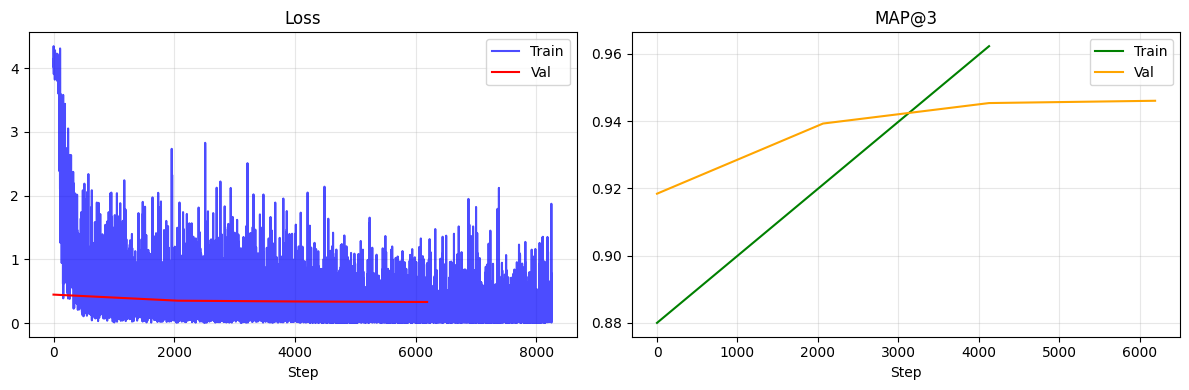

Final - Train Loss: 0.0468
Final - Val Loss: 0.3301
Final - Train MAP@3: 0.9623
Final - Val MAP@3: 0.9461


In [25]:
plot_metrics(METRICS)

# Conclusion 

- Try out more different batch size, lr, modules...

All the best! Enjoy the process!